In [53]:
import numpy as np
np.random.seed(42)
import pandas as pd
import seaborn as sns
from subprocess import check_output
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb
# from sklearn.externals import joblib
from joblib import dump, load
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from evolutionary_search import EvolutionaryAlgorithmSearchCV
%matplotlib inline

In [54]:
# Util functions
def process_data_target(df,
                        filter_regex='target',
                        target_col='target',
                        anomaly_mapping=None):
    """
    Loads dataframe and creates tokenized single target column.
    :param df: dataframe to be loaded
    :param filter_regex: regex used to filter only target columns (contaning class labels)
    :param target_col: defines the name of the targer column
    :param anomaly_mapping: preliminary mapping of anomalies and tokens
    :return: dataframe with singled merged target column
    """
    # Cleanup unwanted columns
    try:
        df.drop(["Unnamed: 0"], axis=1, inplace=True)
    except Exception:
        pass
    # Get only columns based on regex
    df_filtered = df.filter(like=filter_regex, axis=1)
    # Check for duplicate
    test = df_filtered[df_filtered.columns.values].sum(axis=1)
    assert len(set(test))==2
    # Get column names from filtered df
    filtered_columns = df_filtered.columns.values
    # print(filtered_columns)
    if anomaly_mapping is None:
        anomaly_mapping = {
        "target_cpu_master": 1,
        "target_mem_master": 2,
        "target_copy_master": 3,
        "target_dummy_master": 4,
        "target_ddot_master": 5,
        }
    # Tokenize targets based in anomaly mapping
    for c in filtered_columns:
        df_filtered[c].replace(1, anomaly_mapping[c], inplace=True)

    # print(df_filtered[df_filtered.columns.values].sum(axis=1))    # Add up all columns into a single one, checked before with assert the length
    df_filtered[target_col] = df_filtered[df_filtered.columns.values].sum(axis=1)

    # Reverse mapping from tokenized to string labels as per anomaly mapping
    mapping_inverse = dict(zip(anomaly_mapping.values(), anomaly_mapping.keys()))
    anomaly_mapping_inverse = {}
    anomaly_mapping_inverse['target'] = mapping_inverse
    # print(anomaly_mapping_inverse)
    df_filtered.replace(anomaly_mapping_inverse, inplace=True)

    # Drop unwanted columns
    df.drop(filtered_columns, axis=1, inplace=True)

    # Add newly tokenized data to original df
    df[target_col] = df_filtered[target_col]
    print("Class distribution:")
    print(df[target_col].value_counts(normalize=True))
    return df

def plot_on_features(data,
                     features=[],
                     target_col='target'):
    """
    :param data: dataset used for training or prediction
    :param features: features to be ploted
    :param target_col: column to use as target

    :return: 0
    """
    if not features:
        col_names_plt = list(data.columns.values)
    else:
        col_names_plt = features

    for feature in col_names_plt:
        if feature == 'time' or feature == target_col:
            pass
        else:
            # fig, ax = plt.subplots(figsize=(15,10))
            a = data[data[target_col] == 'target_cpu_master'] #class
            b = data[data[target_col] == 'target_mem_master'] #class
            c = data[data[target_col] == 'target_copy_master'] #class
            d = data[data[target_col] == 'target_ddot_master'] #class
            _ = plt.figure(figsize=(15,5))
            _ = plt.plot(data[feature], color='blue', label='Normal')
            _ = plt.plot(a[feature], linestyle='none', marker='X', color='red', markersize=4, label='CPU')
            _ = plt.plot(b[feature], linestyle='none', marker='o', color='green', markersize=4, label='MEM')
            _ = plt.plot(c[feature], linestyle='none', marker='*', color='m', markersize=4, label='COPY')
            _ = plt.plot(d[feature], linestyle='none', marker='.', color='y', markersize=4, label='DDOR')
            _ = plt.xlabel('Time')
            _ = plt.ylabel(f'{feature}')
            _ = plt.title(f'Anomaly Classes for {feature}')
            _ = plt.grid()
            _ = plt.legend(loc='best')
            plt.show();

def filter_low_variance(list_df):
    """
    Finds low variance columns from a list of datasets, must be the same shape
    :param list_df:
    :return: list containing low variance features
    """
    # Get Column file
    column_size = []
    for d in list_df:
        column_size.append(d.shape[-1])
    items = Counter(column_size).keys()
    print("Unique column size: {}".format(items))
    print(f"Columns found: {list_df[0].columns}")

    df_work = list_df[0]
    print("Checking low variance columns ...")
    print("Starting Clean dataset")
    uniques = df_work.apply(lambda x: x.nunique())
    rm_columns = []
    for uindex, uvalue in uniques.iteritems():
        if uvalue == 1:
            rm_columns.append(uindex)
    print("First pass columns to be removed")
    print(rm_columns)

    # Find common low variance elements in list of low variance columns
    list_low_varaince = []
    for df in list_df:
    # Check for monotonous columns and remove them
        print("Checking low variance columns ...")
        print("Starting Clean dataset")
        uniques = df.apply(lambda x: x.nunique())
        rm_columns = []
        for uindex, uvalue in uniques.iteritems():
            if uvalue == 1:
                rm_columns.append(uindex)
        print(rm_columns)
        list_low_varaince.append(rm_columns)

    common_low_variance = list(set.intersection(*map(set, list_low_varaince)))
    print("Common low variance columns:")
    print(common_low_variance)
    return common_low_variance


In [70]:
print("Checking files in data location ...")
drop_dir = '/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node'
print(check_output(["ls", drop_dir]).decode("utf8"))

# Load Dataframse
print("Loading Single node no overlap data ...")
df_clean_single = pd.read_csv(os.path.join(drop_dir,"df_clean_single_node.csv"))
df_clean_ausdome_single = pd.read_csv(os.path.join(drop_dir,"df_clean_audsome_single_node.csv"))
df_anomaly_single = pd.read_csv(os.path.join(drop_dir,"df_anomaly_single_node.csv"))
df_audsome_anomaly = pd.read_csv(os.path.join(drop_dir,"df_anomaly_audsome_single_nooverlap.csv"))

Checking files in data location ...
df_anomaly_audsome_single_nooverlap.csv
df_anomaly_audsome_single_overlap.csv
df_anomaly_single_node.csv
df_anomaly_single_overlap.csv
df_clean_audsome_single_node.csv
df_clean_single_node.csv



In [71]:
list_df = [df_clean_single, df_clean_ausdome_single, df_anomaly_single, df_audsome_anomaly]
low_varaiance_features = filter_low_variance(list_df=list_df)

Unique column size: dict_keys([199])
Columns found: Index(['node_arp_entries_10.251.0.114:9100',
       'node_boot_time_seconds_10.251.0.114:9100',
       'node_context_switches_total_10.251.0.114:9100',
       'node_cpu_guest_seconds_total_10.251.0.114:9100',
       'node_cpu_seconds_total_10.251.0.114:9100',
       'node_disk_io_now_10.251.0.114:9100',
       'node_disk_io_time_seconds_total_10.251.0.114:9100',
       'node_disk_io_time_weighted_seconds_total_10.251.0.114:9100',
       'node_disk_read_bytes_total_10.251.0.114:9100',
       'node_disk_read_time_seconds_total_10.251.0.114:9100',
       ...
       'node_vmstat_pgpgin_10.251.0.114:9100',
       'node_vmstat_pgpgout_10.251.0.114:9100',
       'node_vmstat_pswpin_10.251.0.114:9100',
       'node_vmstat_pswpout_10.251.0.114:9100', 'target_cpu_master',
       'target_mem_master', 'target_copy_master', 'target_dummy_master',
       'target_ddot_master', 'time'],
      dtype='object', length=199)
Checking low variance columns 

In [72]:
print("Data shape before low variance drop:")
print(f"Clean {df_clean_single.shape}")
print(f"Clean AUDSOME {df_clean_ausdome_single.shape}")
print(f"Anomaly {df_anomaly_single.shape}")
print(f"Anomaly AUDSOME {df_audsome_anomaly.shape}\n")

df_clean_single.drop(low_varaiance_features, inplace=True, axis=1)
df_clean_ausdome_single.drop(low_varaiance_features, inplace=True, axis=1)
df_anomaly_single.drop(low_varaiance_features, inplace=True, axis=1)
df_audsome_anomaly.drop(low_varaiance_features, inplace=True, axis=1)

print("Data shape after low variance drop:")
print(f"Clean {df_clean_single.shape}")
print(f"Clean AUDSOME {df_clean_ausdome_single.shape}")
print(f"Anomaly {df_anomaly_single.shape}")
print(f"Anomaly AUDSOME {df_audsome_anomaly.shape}")

Data shape before low variance drop:
Clean (3900, 199)
Clean AUDSOME (12000, 199)
Anomaly (5400, 199)
Anomaly AUDSOME (4800, 199)

Data shape after drop low variance:
Clean (3900, 94)
Clean AUDSOME (12000, 94)
Anomaly (5400, 94)
Anomaly AUDSOME (4800, 94)


In [65]:
print("Checking dataframe header integrity ...")
assert len(df_clean_single.columns.difference(df_clean_ausdome_single.columns)) == 0
assert len(df_clean_single.columns.difference(df_anomaly_single.columns)) == 0
assert len(df_clean_single.columns.difference(df_audsome_anomaly.columns)) == 0
print("Integrity check passed!")

Checking dataframe header integrity ...
Integrity check passed!


In [73]:
# for r in df_anomaly_single_filtered.iterrows():
#     print(r)
# df_anomaly_single_filtered.loc[df_anomaly_single_filtered['target_mem_master'] == 2]
# df_anomaly_single_filtered.loc[df_anomaly_single_filtered['target_ddot_master'] == 'target_ddot_master']
# df_anomaly_single_filtered.loc[df_anomaly_single_filtered['target_copy_master'] == 'target_copy_master']

In [74]:
# df_anomaly_single.loc[df_anomaly_single['target_cpu_master'] == 1]


print("Processing single anomaly data ...\n")
df_anomaly = process_data_target(df=df_anomaly_single)

print("Processing single anomaly AUDSOME data ...\n")
df_audsome = process_data_target(df=df_audsome_anomaly)

Processing single anomaly data ...
Class distribution:
0                     0.887407
target_copy_master    0.059444
target_mem_master     0.024444
target_ddot_master    0.016852
target_cpu_master     0.011852
Name: target, dtype: float64
Processing single anomaly AUDSOME data ...
Class distribution:
0                     0.792292
target_ddot_master    0.066042
target_copy_master    0.056042
target_mem_master     0.055833
target_cpu_master     0.029792
Name: target, dtype: float64


/Users/Gabriel/anaconda3/envs/p3envmlv2/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-54-0dd1cd690e81>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[target_col] = df_filtered[df_filtered.columns.values].sum(axis=1)
/Users/Gabriel/anaconda3/envs/p3envmlv2/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

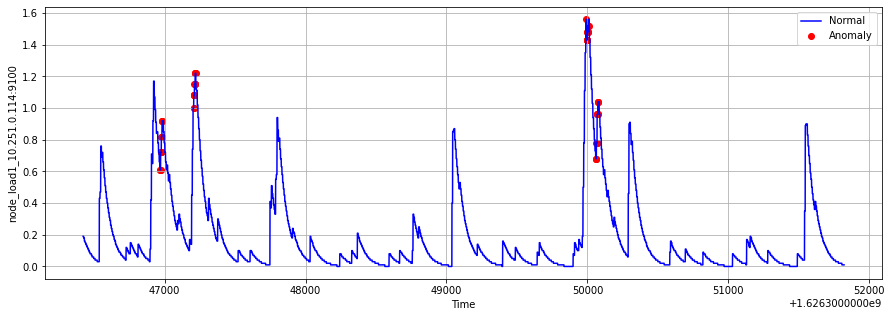

In [46]:
fig, ax = plt.subplots(figsize=(15,5))
a = df_anomaly.loc[df_anomaly['target'] == "target_cpu_master", ['time', "node_load1_10.251.0.114:9100"]] #anomaly
ax.plot(df_anomaly['time'], df_anomaly['node_load1_10.251.0.114:9100'], color='blue', label='Normal')
ax.scatter(a['time'],a["node_load1_10.251.0.114:9100"], color='red', label='Anomaly')
plt.xlabel('Time')
plt.ylabel('node_load1_10.251.0.114:9100')
plt.grid()
plt.legend()
plt.show();

Ploting class distribution ..


/Users/Gabriel/anaconda3/envs/p3envmlv2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


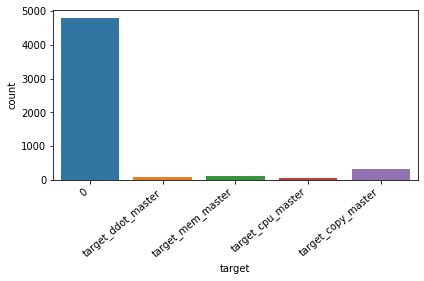

In [47]:
# Plot class distribution
print("Ploting class distribution ..")
pltdist = sns.countplot(df_anomaly['target'])
pltdist.set_xticklabels(pltdist.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()



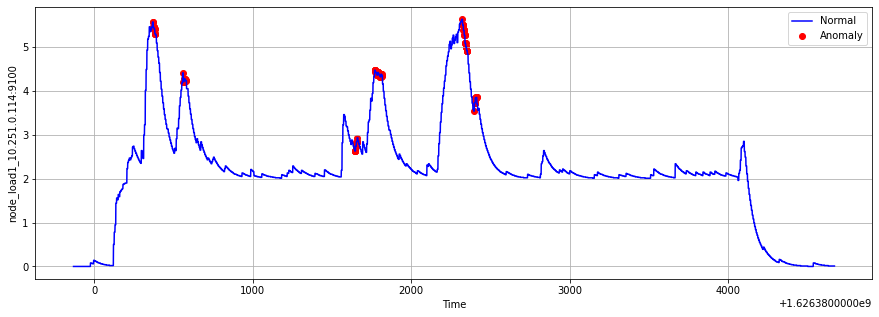

In [48]:
fig, ax = plt.subplots(figsize=(15,5))
a = df_audsome.loc[df_audsome['target'] == "target_cpu_master", ['time', "node_load1_10.251.0.114:9100"]] #anomaly
ax.plot(df_audsome['time'], df_audsome['node_load1_10.251.0.114:9100'], color='blue', label='Normal')
ax.scatter(a['time'],a["node_load1_10.251.0.114:9100"], color='red', label='Anomaly')
plt.xlabel('Time')
plt.ylabel('node_load1_10.251.0.114:9100')
plt.grid()
plt.legend()
plt.show();

Ploting class distribution ..


/Users/Gabriel/anaconda3/envs/p3envmlv2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


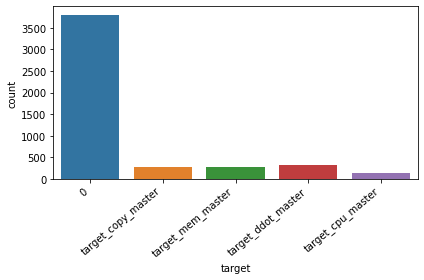

In [49]:
# Plot class distribution
print("Ploting class distribution ..")
pltdist = sns.countplot(df_audsome['target'])
pltdist.set_xticklabels(pltdist.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


In [50]:
#TODO: compute rate  metrics



In [52]:
# plot_on_features(data=df_anomaly)

Error in callback <function flush_figures at 0x7fe4c07f53a0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Pairplot of data (if to large it will look bad)
# sns.pairplot(df_anomaly, hue='target', vars=[columns_names]) # can specify column names
sns.pairplot(df_anomaly, hue='target')

KeyboardInterrupt: 